In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
df=pd.read_csv("heart.csv",sep=',')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
y=df['target']
df.drop('target',axis=1,inplace=True)
numberOfAtributtes= len(df.columns)
print(numberOfAtributtes) 

13


In [7]:
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
mms = MinMaxScaler()
df_norm = mms.fit_transform(df)
clf = SVC()
scores = model_selection.cross_val_score(clf, df_norm, y,
 cv=5, scoring='accuracy',
n_jobs=-1)
print(scores.mean()) 

0.8314754098360657


In [8]:
import random
def SVCParameters(numberFeatures,icls):
 genome = list()
 #kernel
 listKernel = ["linear","rbf", "poly","sigmoid"]
 genome.append(listKernel[random.randint(0, 3)])
 #c
 k = random.uniform(0.1, 100)
 genome.append(k)
 #degree
 #genome.append(random.int(0.1,5)) # TODO: z pliku i daje errory
 genome.append(random.randint(0,5)) # podmienione
 #gamma
 gamma = random.uniform(0.001,5)
 genome.append(gamma)
 # coeff
 coeff = random.uniform(0.01, 10)
 genome.append(coeff)
 return icls(genome) 


In [9]:
import math
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

def SVCParametersFitness(y,df,numberOfAtributtes,individual):
    split=5
    cv = StratifiedKFold(n_splits=split)
    mms = MinMaxScaler()
    df_norm = mms.fit_transform(df)
    estimator = SVC(kernel=individual[0],C=individual[1],degree=individual[2],gamma=individual[3],coef0=individual[4],random_state=101)
    resultSum = 0
    for train, test in cv.split(df_norm, y):
        estimator.fit(df_norm[train], y[train])
        predicted = estimator.predict(df_norm[test])
        expected = y[test]
        tn, fp, fn, tp = metrics.confusion_matrix(expected,predicted).ravel()
        result = (tp + tn) / (tp + fp + tn + fn) #w oparciu o macierze pomyłek https://www.dataschool.io/simple-guide-to-confusion-matrixterminology/
    resultSum = resultSum + result #zbieramy wyniki z poszczególnychetapów walidacji krzyżowej
    return resultSum / split,

fitness_function = SVCParametersFitness

In [10]:
def mutationSVC(individual):
    numberParamer= random.randint(0,len(individual)-1)
    if numberParamer==0:
        # kernel
        listKernel = ["linear", "rbf", "poly", "sigmoid"]
        individual[0]=listKernel[random.randint(0, 3)]
    elif numberParamer==1:
        #C
        k = random.uniform(0.1,100)
        individual[1]=k
    elif numberParamer == 2:
        #degree
        #individual[2]=random.uniform(0.1, 5) # TODO: z pliku daje errora
        individual[2]=random.randint(0,5) # podmienione
    elif numberParamer == 3:
        #gamma
        gamma = random.uniform(0.01, 5)
        individual[3]=gamma
    elif numberParamer ==4:
        # coeff
        coeff = random.uniform(0.1, 20)
        individual[4] = coeff


In [11]:
import time 

import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

minValue = -10
maxValue = 10
bitsLength = 20
sizePopulation = 100
probabilityMutation = 0.2
probabilityCrossover = 0.8
numberIteration = 100

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('individual',SVCParameters, numberOfAtributtes, creator.Individual) # PROJEKT 4
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", SVCParametersFitness,y,df,numberOfAtributtes) # PROJEKT 4

toolbox.register('select', tools.selWorst)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", mutationSVC) # PROJEKT 4

pop = toolbox.population(n=sizePopulation)
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

g = 0
min_data = []
max_data = []
avg_data = []
std_data = []
numberElitism = 1
t_start = time.time()
while g < numberIteration:
    g = g + 1
    print("-- Generation %i --" % g)
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    listElitism = []
    for x in range(0, numberElitism):
        listElitism.append(tools.selBest(pop, 1)[0])

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        # cross two individuals with probability CXPB
        if random.random() < probabilityCrossover:
            toolbox.mate(child1, child2)
            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        # mutate an individual with probability MUTPB
        if random.random() < probabilityMutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))
    pop[:] = offspring + listElitism
    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5
    min_data.append(min(fits))
    max_data.append(max(fits))
    avg_data.append(mean)
    std_data.append(std)
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
runtime = time.time() - t_start
print(f"{runtime * 1000:.2f} ms & {min(fits):.5f} & {sum(std_data)/len(std_data):.2f}")
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
print("-- End of (successful) evolution --")
plt.figure(figsize=(7, 7))
plt.subplot(2,2,1)
plt.plot(avg_data, label='Średnia')
plt.title("Średnia")
plt.subplot(2,2,2)
plt.title("Wartość minimalna")
plt.plot(min_data, label='Minimum')
plt.subplot(2,2,3)
plt.plot(max_data, label='Maksimum')
plt.title("Wartość maksymalna")
plt.subplot(2,2,4)
plt.plot(std_data)
plt.title("Wartość odchylenia standardowego")
plt.show()

/Users/kamil/.pyenv/versions/3.10.0/envs/test_project/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/kamil/.pyenv/versions/3.10.0/envs/test_project/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


-- Generation 1 --
  Evaluated 81 individuals
  Min 0.11000000000000001
  Max 0.16666666666666669
  Avg 0.14478547854785473
  Std 0.01754087379162958
-- Generation 2 --
  Evaluated 81 individuals
  Min 0.11000000000000001
  Max 0.16666666666666669
  Avg 0.14571895424836595
  Std 0.0167408639343402
-- Generation 3 --
  Evaluated 78 individuals
  Min 0.11000000000000001
  Max 0.16666666666666669
  Avg 0.1446278317152103
  Std 0.017840435084192537
-- Generation 4 --
  Evaluated 82 individuals
  Min 0.11000000000000001
  Max 0.16666666666666669
  Avg 0.14298076923076913
  Std 0.01882736613676083
-- Generation 5 --


KeyboardInterrupt: 

In [ ]:
# Best individual is ['sigmoid', 94.3504115183792, 3, 2.679887681802591, 18.30499836479284], (0.11000000000000001,)
ind = ['sigmoid', 94.3504115183792, 3, 2.679887681802591, 18.30499836479284]
print(SVCParametersFitness(y,df,numberOfAtributtes,ind)) 

(0.11000000000000001,)


## COPY THE THIS MAIN FILE AND MODIFY THE CODE SO IT GIVES YOU THE IMPORTANT PARAMETERS AS WELL


In [12]:
def SVCParametersFeatures(numberFeatures,icls):
    genome = list()
    # kernel
    listKernel = ["linear","rbf", "poly", "sigmoid"]
    genome.append(listKernel[random.randint(0, 3)])
    #c
    k = random.uniform(0.1, 100)
    genome.append(k)
    #degree
    genome.append(random.randint(0,5))
    #gamma
    gamma = random.uniform(0.001,5)
    genome.append(gamma)
    # coeff
    coeff = random.uniform(0.01, 10)
    genome.append(coeff)
    
    for i in range(0,numberFeatures):
        genome.append(random.randint(0, 1))

    return icls(genome) 

In [13]:
def SVCParametersFeatureFitness(y,df,numberOfAtributtes,individual):
    split=5
    cv = StratifiedKFold(n_splits=split)

    listColumnsToDrop=[] #lista cech do usuniecia
    for i in range(numberOfAtributtes,len(individual)):
        if individual[i]==0: #gdy atrybut ma zero to usuwamy cechę
            listColumnsToDrop.append(i-numberOfAtributtes)
    
    dfSelectedFeatures=df.drop(df.columns[listColumnsToDrop], axis=1, inplace=False)

    mms = MinMaxScaler()
    df_norm = mms.fit_transform(dfSelectedFeatures)
    estimator = SVC(kernel=individual[0],C=individual[1],degree=individual[2],gamma=individual[3],coef0=individual[4],random_state=101) 

    resultSum = 0
    for train, test in cv.split(df_norm, y):
        estimator.fit(df_norm[train], y[train])
        predicted = estimator.predict(df_norm[test])
        expected = y[test]
        tn, fp, fn, tp = metrics.confusion_matrix(expected, predicted).ravel()
        result = (tp + tn) / (tp + fp + tn + fn) #w oparciu o macierze pomyłek https://www.dataschool.io/simple-guide-to-confusion-matrixterminology/
        resultSum = resultSum + result #zbieramy wyniki z poszczególnych etapów walidacji krzyżowej
    return resultSum / split,

In [14]:
def mutationSVC(individual):
    numberParamer= random.randint(0,len(individual)-1)
    if numberParamer==0:
        # kernel
        listKernel = ["linear", "rbf", "poly", "sigmoid"]
        individual[0]=listKernel[random.randint(0, 3)]
    elif numberParamer==1:
        #C
        k = random.uniform(0.1,100)
        individual[1]=k
    elif numberParamer == 2:
        #degree
        individual[2]=random.randint(0, 5)
    elif numberParamer == 3:
        #gamma
        gamma = random.uniform(0.01, 1)
        individual[3]=gamma
    elif numberParamer ==4:
        # coeff
        coeff = random.uniform(0.1, 1)
        individual[4] = coeff
    else: #genetyczna selekcja cech
        if individual[numberParamer] == 0:
            individual[numberParamer] = 1
        else:   
            individual[numberParamer] = 0

/Users/kamil/.pyenv/versions/3.10.0/envs/test_project/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/kamil/.pyenv/versions/3.10.0/envs/test_project/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


-- Generation 1 --
  Evaluated 66 individuals
  Min 0.5445901639344262
  Max 0.8480874316939891
  Avg 0.7199767353784561
  Std 0.10739687406849867
-- Generation 2 --
  Evaluated 86 individuals
  Min 0.5445901639344262
  Max 0.8513661202185793
  Avg 0.7183633344048005
  Std 0.11135076305719846
-- Generation 3 --
  Evaluated 85 individuals
  Min 0.5445901639344262
  Max 0.8446448087431694
  Avg 0.7157048119263626
  Std 0.11145096245595709
-- Generation 4 --
  Evaluated 80 individuals
  Min 0.5445901639344262
  Max 0.8382513661202186
  Avg 0.7102159520807068
  Std 0.11205014005947975
-- Generation 5 --
  Evaluated 85 individuals
  Min 0.5445901639344262
  Max 0.8480874316939891
  Avg 0.7152422586520952
  Std 0.11099337297382432
-- Generation 6 --
  Evaluated 84 individuals
  Min 0.5445901639344262
  Max 0.8480874316939891
  Avg 0.7122976595525319
  Std 0.1112706422036637
-- Generation 7 --
  Evaluated 89 individuals
  Min 0.5445901639344262
  Max 0.8480874316939891
  Avg 0.715316888820796

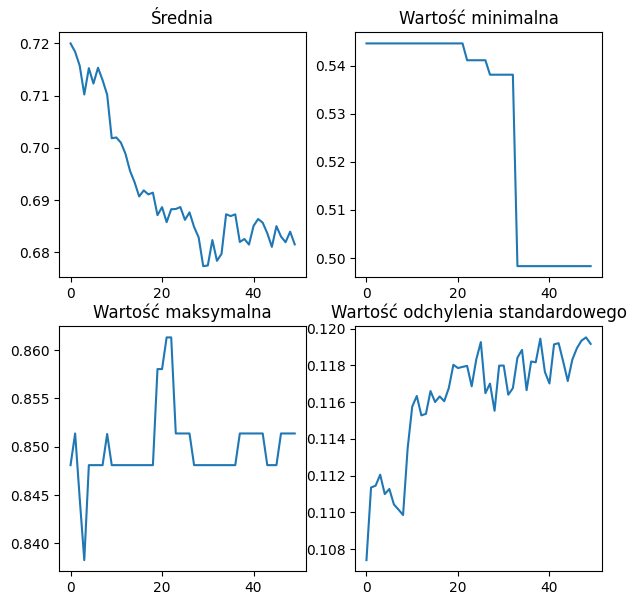

In [15]:
import time 

import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

minValue = -10
maxValue = 10
bitsLength = 20
sizePopulation = 100
probabilityMutation = 0.2
probabilityCrossover = 0.8
numberIteration = 50

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('individual',SVCParametersFeatures, numberOfAtributtes, creator.Individual) # PROJEKT 4
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", SVCParametersFeatureFitness,y,df,numberOfAtributtes) # PROJEKT 4

toolbox.register('select', tools.selWorst)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", mutationSVC) # PROJEKT 4

pop = toolbox.population(n=sizePopulation)
fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

g = 0
min_data = []
max_data = []
avg_data = []
std_data = []
numberElitism = 1
t_start = time.time()
while g < numberIteration:
    g = g + 1
    print("-- Generation %i --" % g)
    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    listElitism = []
    for x in range(0, numberElitism):
        listElitism.append(tools.selBest(pop, 1)[0])

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        # cross two individuals with probability CXPB
        if random.random() < probabilityCrossover:
            toolbox.mate(child1, child2)
            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values
    for mutant in offspring:
        # mutate an individual with probability MUTPB
        if random.random() < probabilityMutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(invalid_ind))
    pop[:] = offspring + listElitism
    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]
    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5
    min_data.append(min(fits))
    max_data.append(max(fits))
    avg_data.append(mean)
    std_data.append(std)
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)
runtime = time.time() - t_start
print(f"{runtime * 1000:.2f} ms & {min(fits):.5f} & {sum(std_data)/len(std_data):.2f}")
best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
print("-- End of (successful) evolution --")
plt.figure(figsize=(7, 7))
plt.subplot(2,2,1)
plt.plot(avg_data, label='Średnia')
plt.title("Średnia")
plt.subplot(2,2,2)
plt.title("Wartość minimalna")
plt.plot(min_data, label='Minimum')
plt.subplot(2,2,3)
plt.plot(max_data, label='Maksimum')
plt.title("Wartość maksymalna")
plt.subplot(2,2,4)
plt.plot(std_data)
plt.title("Wartość odchylenia standardowego")
plt.show()

In [19]:
# Best individual is ['sigmoid', 90.7311200728442, 2, 1.8106432181357668, 0.7414036817486512, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1], (0.5083060109289617,)
ind = ['sigmoid', 92.43575045864539, 3, 1.9413608683024546, 0.37238740765855727, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]
print(SVCParametersFeatureFitness(y,df,numberOfAtributtes,ind))  # Cos ta wartosc sie nie pokrywa #TODO
# print(SVCParametersFitness(y,df,numberOfAtributtes,ind))  # Cos ta wartosc sie nie pokrywa #TODO

(0.49830601092896176,)
